In [1]:
import sys
sys.path.append("../")
from data_loader.multiwoz_loader import load_multiwoz_dataset
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns


# 1. Dataset Overview

In [2]:
dataset = load_multiwoz_dataset(data_dir="../data/multiwoz_2.1", split='all')

In [3]:

print("Dataset Splits:", dataset.keys())
for split in dataset:
    print(f"\n=== {split.upper()} Split ===")
    ds = dataset[split]
    print(f"Total turns: {len(ds)}")
    print(f"Columns: {ds.column_names}")

Dataset Splits: dict_keys(['train', 'dev', 'test'])

=== TRAIN Split ===
Total turns: 56668
Columns: ['dialogue_id', 'turn_idx', 'user', 'system', 'belief_state', 'turn_label']

=== DEV Split ===
Total turns: 7374
Columns: ['dialogue_id', 'turn_idx', 'user', 'system', 'belief_state', 'turn_label']

=== TEST Split ===
Total turns: 7368
Columns: ['dialogue_id', 'turn_idx', 'user', 'system', 'belief_state', 'turn_label']


# 2. Turn-Level Statistics

In [4]:
all_dialogues = set()
turn_counts = Counter()

for split in dataset:
    ds = dataset[split]
    for example in ds:
        all_dialogues.add(example["dialogue_id"])
        turn_counts[example["dialogue_id"]] += 1

print(f"\nTotal unique dialogues: {len(all_dialogues)}")
print(f"Average turns per dialogue: {sum(turn_counts.values()) / len(all_dialogues):.2f}")


Total unique dialogues: 10419
Average turns per dialogue: 6.85


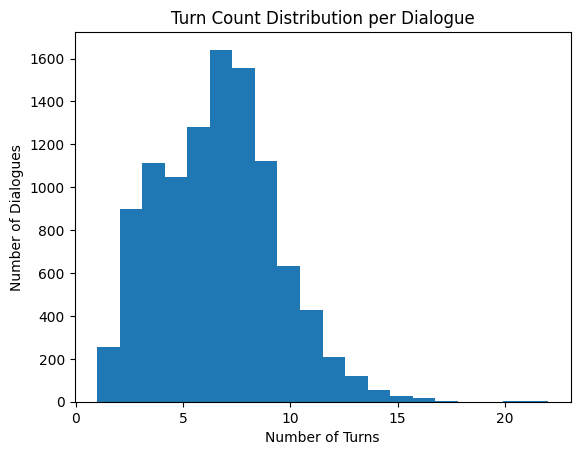

In [5]:
# Turn count distribution
plt.hist(turn_counts.values(), bins=20)
plt.title("Turn Count Distribution per Dialogue")
plt.xlabel("Number of Turns")
plt.ylabel("Number of Dialogues")
plt.show()

# 3. Belief State Analysis

In [6]:
slot_counter = Counter()
belief_lengths = []

for split in dataset:
    for example in dataset[split]:
        belief_lengths.append(len(example["belief_state"]))
        for slot in example["belief_state"].keys():
            slot_counter[slot] += 1

print(f"\nTotal unique slots: {len(slot_counter)}")
print("Most common slots:", slot_counter.most_common(10))


Total unique slots: 31
Most common slots: [('attraction-area', 71410), ('attraction-name', 71410), ('attraction-type', 71410), ('hotel-area', 71410), ('hotel-book day', 71410), ('hotel-book people', 71410), ('hotel-book stay', 71410), ('hotel-internet', 71410), ('hotel-name', 71410), ('hotel-parking', 71410)]


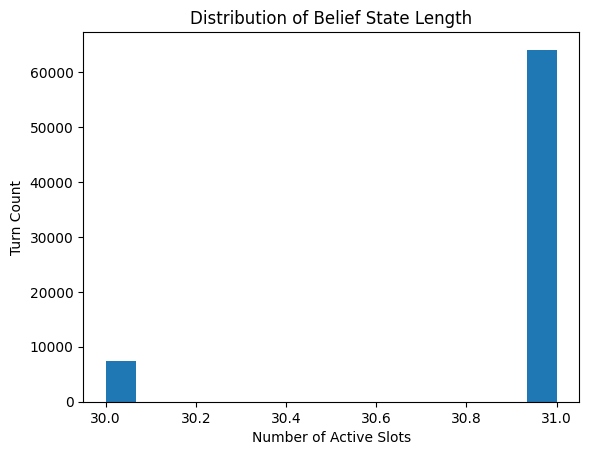

In [7]:
plt.hist(belief_lengths, bins=15)
plt.title("Distribution of Belief State Length")
plt.xlabel("Number of Active Slots")
plt.ylabel("Turn Count")
plt.show()

# 4. Turn Label Analysis

In [8]:
turn_label_counter = Counter()
total_turns_with_label = 0

for split in dataset:
    for example in dataset[split]:
        if example["turn_label"]:
            total_turns_with_label += 1
            for slot, value in example["turn_label"]:
                turn_label_counter[slot] += 1

print(f"\nTotal turns with turn_label: {total_turns_with_label}")
print("Most common slots updated in turn_label:", turn_label_counter.most_common(10))



Total turns with turn_label: 46435
Most common slots updated in turn_label: [('restaurant-food', 4968), ('train-destination', 3963), ('train-departure', 3926), ('train-day', 3852), ('restaurant-area', 3627), ('restaurant-pricerange', 3489), ('restaurant-name', 3457), ('hotel-name', 3313), ('attraction-type', 3084), ('restaurant-book time', 3048)]



Total Dialogues: 10419
Average Turns per Dialogue: 6.85


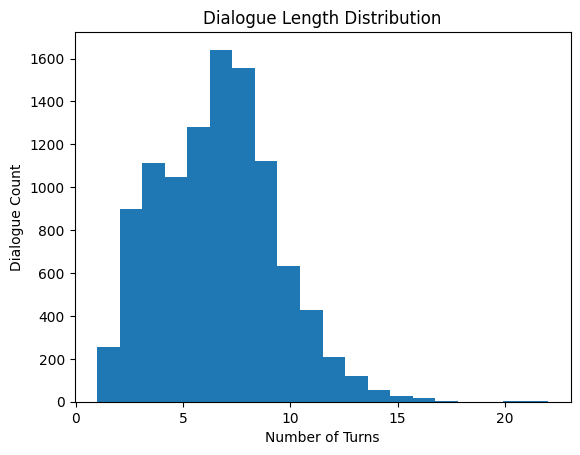

In [9]:
# --- Dialogue ID and Turn Distribution ---
dialogue_turns = defaultdict(list)

for split in dataset:
    for ex in dataset[split]:
        dialogue_turns[ex["dialogue_id"]].append(ex)

print(f"\nTotal Dialogues: {len(dialogue_turns)}")
turn_lengths = [len(turns) for turns in dialogue_turns.values()]
print(f"Average Turns per Dialogue: {sum(turn_lengths)/len(turn_lengths):.2f}")

plt.hist(turn_lengths, bins=20)
plt.title("Dialogue Length Distribution")
plt.xlabel("Number of Turns")
plt.ylabel("Dialogue Count")
plt.show()


In [10]:
# --- Dialogue Example Preview ---
sample_dialogue = next(iter(dialogue_turns.values()))
print("\n=== Example Dialogue ===")
for turn in sample_dialogue:
    print(f"\nTurn {turn['turn_idx']}")
    print(f"User: {turn['user']}")
    print(f"System: {turn['system']}")
    print(f"Belief State: {turn['belief_state']}")
    print(f"Turn Label: {turn['turn_label']}")



=== Example Dialogue ===

Turn 0
User: am looking for a place to to stay that has cheap price range it should be in a type of hotel
System: 
Belief State: {'attraction-area': None, 'attraction-name': None, 'attraction-type': None, 'hospital-department': None, 'hotel-area': None, 'hotel-book day': None, 'hotel-book people': None, 'hotel-book stay': None, 'hotel-internet': None, 'hotel-name': None, 'hotel-parking': None, 'hotel-pricerange': 'cheap', 'hotel-stars': None, 'hotel-type': 'hotel', 'restaurant-area': None, 'restaurant-book day': None, 'restaurant-book people': None, 'restaurant-book time': None, 'restaurant-food': None, 'restaurant-name': None, 'restaurant-pricerange': None, 'taxi-arriveby': None, 'taxi-departure': None, 'taxi-destination': None, 'taxi-leaveat': None, 'train-arriveby': None, 'train-book people': None, 'train-day': None, 'train-departure': None, 'train-destination': None, 'train-leaveat': None}
Turn Label: [['hotel-pricerange', 'cheap'], ['hotel-type', 'hotel'


Domain Distribution (from slot names):
hotel: 714100
restaurant: 499870
train: 428460
taxi: 285640
attraction: 214230
hospital: 64042


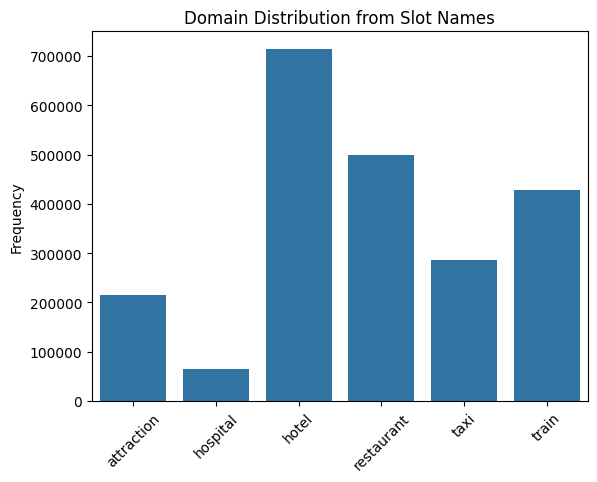

In [11]:
# --- Domain Distribution (if applicable) ---
# In MultiWOZ, domains often appear as part of slot names, e.g., "hotel-area"
domain_counter = Counter()

for split in dataset:
    for ex in dataset[split]:
        for slot in ex["belief_state"].keys():
            domain = slot.split("-")[0]
            domain_counter[domain] += 1

print("\nDomain Distribution (from slot names):")
for domain, count in domain_counter.most_common():
    print(f"{domain}: {count}")

sns.barplot(x=list(domain_counter.keys()), y=list(domain_counter.values()))
plt.title("Domain Distribution from Slot Names")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.show()


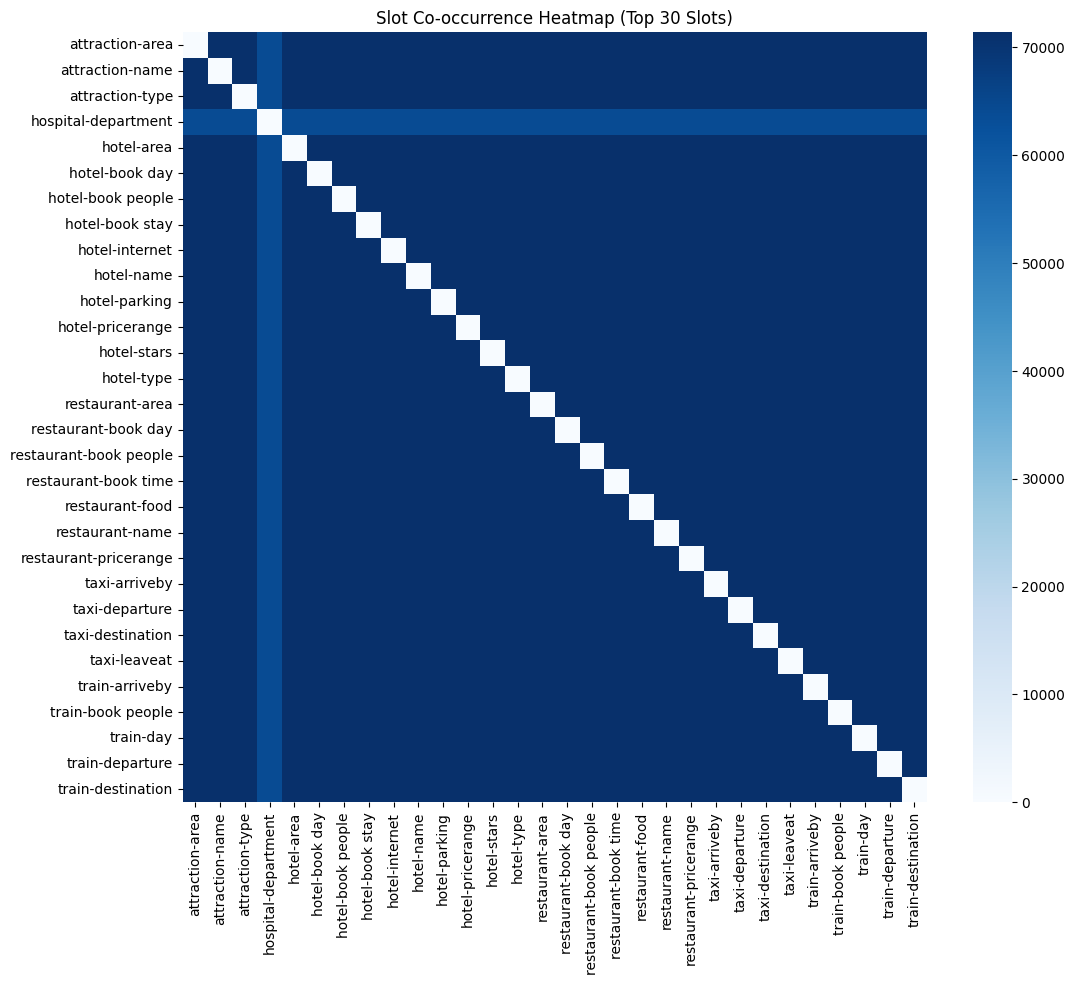

In [12]:
# --- Slot Co-occurrence Heatmap ---
# Count how often pairs of slots appear together in belief state
slot_pair_counter = Counter()
unique_slots = set()

for split in dataset:
    for ex in dataset[split]:
        slots = list(ex["belief_state"].keys())
        unique_slots.update(slots)
        for i in range(len(slots)):
            for j in range(i + 1, len(slots)):
                slot_pair = tuple(sorted((slots[i], slots[j])))
                slot_pair_counter[slot_pair] += 1

# Convert to matrix
slot_list = sorted(list(unique_slots))[:30]  # Top 30 for readability
slot_indices = {s: i for i, s in enumerate(slot_list)}
matrix = [[0] * len(slot_list) for _ in range(len(slot_list))]

for (s1, s2), count in slot_pair_counter.items():
    if s1 in slot_indices and s2 in slot_indices:
        i, j = slot_indices[s1], slot_indices[s2]
        matrix[i][j] = count
        matrix[j][i] = count

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, xticklabels=slot_list, yticklabels=slot_list, cmap="Blues")
plt.title("Slot Co-occurrence Heatmap (Top 30 Slots)")
plt.show()



In [13]:
# --- Belief State Progression within a Dialogue ---
print("\n=== Belief State Progression Example ===")
prev_belief = {}
for turn in sample_dialogue:
    current_belief = turn["belief_state"]
    updates = {k: v for k, v in current_belief.items() if prev_belief.get(k) != v}
    print(f"\nTurn {turn['turn_idx']} | User: {turn['user']}")
    print(f"Updated Slots: {updates}")
    prev_belief = current_belief



=== Belief State Progression Example ===

Turn 0 | User: am looking for a place to to stay that has cheap price range it should be in a type of hotel
Updated Slots: {'hotel-pricerange': 'cheap', 'hotel-type': 'hotel'}

Turn 1 | User: no , i just need to make sure it s cheap . oh , and i need parking
Updated Slots: {'hotel-parking': 'yes'}

Turn 2 | User: yes , please . 6 people 3 nights starting on tuesday .
Updated Slots: {'hotel-book day': 'tuesday', 'hotel-book people': '6', 'hotel-book stay': '3'}

Turn 3 | User: how about only 2 nights .
Updated Slots: {'hotel-book stay': '2'}

Turn 4 | User: no , that will be all . goodbye .
Updated Slots: {}


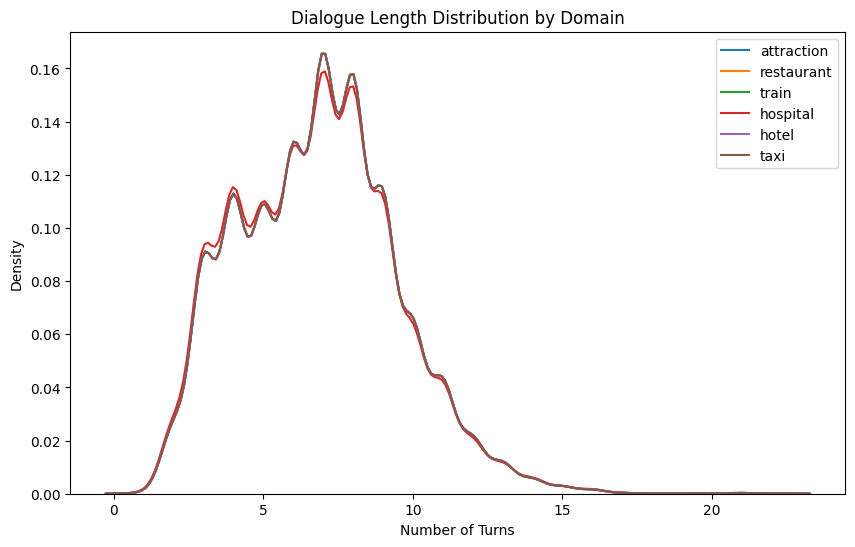

In [14]:
# --- Dialogue Length by Domain (Rough Estimate) ---
dialogue_domains = defaultdict(set)

for split in dataset:
    for ex in dataset[split]:
        domain = [slot.split("-")[0] for slot in ex["belief_state"].keys()]
        dialogue_domains[ex["dialogue_id"]].update(domain)

domain_lengths = defaultdict(list)
for did, domains in dialogue_domains.items():
    length = len(dialogue_turns[did])
    for d in domains:
        domain_lengths[d].append(length)

plt.figure(figsize=(10, 6))
for d, lengths in domain_lengths.items():
    sns.kdeplot(lengths, label=d)
plt.title("Dialogue Length Distribution by Domain")
plt.xlabel("Number of Turns")
plt.ylabel("Density")
plt.legend()
plt.show()



Top 15 Most Frequently Updated Slots:
restaurant-food: 4968
train-destination: 3963
train-departure: 3926
train-day: 3852
restaurant-area: 3627
restaurant-pricerange: 3489
restaurant-name: 3457
hotel-name: 3313
attraction-type: 3084
restaurant-book time: 3048
hotel-book stay: 2988
hotel-area: 2714
restaurant-book day: 2710
hotel-book day: 2690
hotel-type: 2683


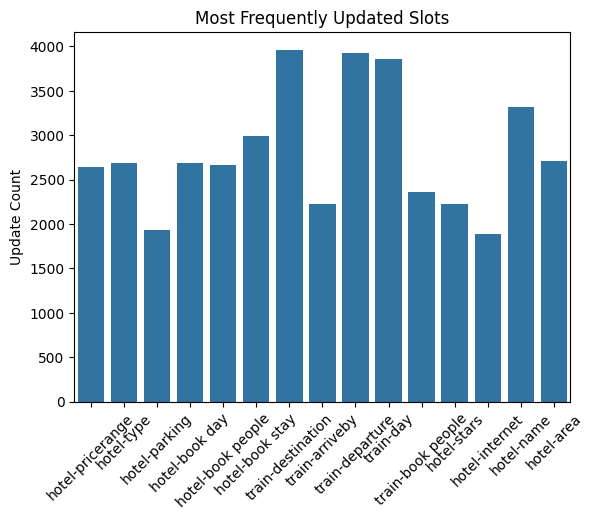

In [15]:
# --- Slot Update Frequency per Turn ---
slot_update_counter = Counter()
for split in dataset:
    for ex in dataset[split]:
        for slot, _ in ex["turn_label"]:
            slot_update_counter[slot] += 1

print("\nTop 15 Most Frequently Updated Slots:")
for slot, count in slot_update_counter.most_common(15):
    print(f"{slot}: {count}")

sns.barplot(x=list(slot_update_counter.keys())[:15], y=list(slot_update_counter.values())[:15])
plt.title("Most Frequently Updated Slots")
plt.xticks(rotation=45)
plt.ylabel("Update Count")
plt.show()
